In [5]:
import torch
import scipy.io
import sklearn.metrics
import sklearn.svm
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [104]:
# OGDOptimizer
class OGDOptimizer(torch.optim.Optimizer):

    # Init Method:
    def __init__(self, params, lr=1e-3):
        super(OGDOptimizer, self).__init__(params, defaults={"lr": lr})
        self.state = dict()

    # Step Method
    def step(self):
        for group in self.param_groups:
            for p in group["params"]:
                p.data = p.data - group["lr"] * p.grad.data


class LinearLoss(torch.nn.Module):
    def __init__(self):
        super(LinearLoss, self).__init__()

    def forward(self, inputs, target):
        loss = torch.max(torch.tensor(0), 1 - target * inputs)
        return loss

In [6]:
mat = scipy.io.loadmat("spam_data.mat")
spam_inst = mat["spam_inst"]
spam_label = mat["spam_label"][:, 0]


T = len(spam_label)
print(T)
B = 2
L = 1

4601


In [7]:
from scipy.optimize import minimize

newinst = spam_inst
newlabel = spam_label

def objective(w):
    return np.sum(np.maximum(0, 1 - newlabel * (newinst.dot(w))))

constraints = {'type': 'ineq', 'fun': lambda w: B - np.linalg.norm(w)}
#by default 'fun' will form >= constaint 
w0 = np.zeros(57)

result = minimize(objective, w0, constraints=constraints, method='SLSQP')

w_opt = result.x
print(w_opt)
print(objective(w_opt))


[-0.02494413 -0.64174644 -0.05605267  0.01715271 -0.06186132 -0.00105784
  0.09661661  0.04292771  0.00913972 -0.07346543  0.01774825 -0.25804386
 -0.01214056 -0.03349026  0.01011063  0.15467172  0.05704427  0.03323278
 -0.41050052  0.04237831  0.0187489   0.01199026  0.04959878  0.05561451
 -0.53123518 -0.25461852 -0.76489171 -0.09102278 -0.12974488 -0.08874032
 -0.0575462  -0.01423997 -0.11403455 -0.01441773 -0.10054311 -0.06477586
 -0.09704728 -0.03659474 -0.10801298 -0.00562839 -0.09135615 -0.27755457
 -0.04246718 -0.16482388 -0.44460153 -0.3207808  -0.00864574 -0.05334203
 -0.01456059 -0.11079468 -0.04366609  0.04801065  0.03503093  0.01003011
 -0.79501553  0.4448493  -1.00320692]
3573.5386744495718


In [8]:
from scipy.optimize import minimize

newinst = spam_inst
newlabel = spam_label

def objective(w):
    return np.sum(np.maximum(0, 1 - newlabel * (newinst.dot(w))))

w0 = np.zeros(57)

result = minimize(objective, w0, method='SLSQP')

w_opt = result.x
print(w_opt)
print(objective(w_opt))


[-2.62109719e+01 -1.66515579e+00 -5.94604643e+00  1.12756356e+02
  9.56079608e-01 -1.45470362e+00  1.06836033e+02  2.30912440e+01
  9.52927728e+00  5.62140060e-01  3.36657550e+00 -1.35786375e+01
 -1.90911795e+01 -7.73838520e+00  2.45034305e+01  3.29729878e+01
  6.52354291e+01 -4.84375795e-01 -1.66060250e+00  9.12598115e+01
 -9.26975822e-01  3.07975319e+01  7.33897206e+01  5.20881667e+00
 -3.90308977e+02 -1.91232200e+00 -1.49568889e+02  7.66509234e+00
 -1.40429046e+02 -1.85553974e+02 -6.35651143e+01  5.21214864e+00
 -1.42313359e+02  1.73948752e+01 -1.31879030e+02 -1.58870282e+01
 -3.06404168e+01 -1.08837042e+02 -6.51030175e+01 -7.15856401e+01
 -1.01204064e+02 -1.67777761e+02 -9.36757137e+01 -1.59714230e+02
 -4.22766733e+01 -2.33561698e+02 -1.43788422e+02 -2.56793656e+02
 -2.32305238e+02 -8.03560909e+01 -1.86061651e+02  4.51284754e+00
  5.25795986e+02  1.36593528e+02 -1.27535463e+01  2.30654181e+00
  5.94920148e-01]
1373.9367956733076


In [ ]:
eta = 1000000
known_spam_inst = []
known_spam_label = []
class_n = 0
class_p = 0
prediction = []
cum_loss3 = 0
loss_avg3 = []
regret3 = []
cum_reg3 = 0
# FTL
for i in range(len(spam_label)):
    if (class_n > 0) + (class_p > 0) != 2:
        if spam_label[i] == -1:
            class_n += 1
        else:
            class_p += 1
        if class_n > class_p:
            prediction.append(-1)
        else:
            prediction.append(1)
        w = np.array([0 for i in range(57)])
        cum_loss3 += max(0, 1 - spam_label[i] * np.dot(w, spam_inst[i]))
        loss_avg3.append(cum_loss3 / (i + 1))
        cum_reg3+=max(0, 1 - spam_label[i] * np.dot(w, spam_inst[i]))-max(0, 1 - spam_label[i] * np.dot(w_opt, spam_inst[i]))
        regret3.append(float(cum_reg3))
    else:
        model = sklearn.svm.LinearSVC(loss="hinge", C=eta, dual="auto", fit_intercept=False)
        model.fit(np.array(known_spam_inst), np.array(known_spam_label))
        p = model.predict(spam_inst[i].reshape(1, -1))
        w = model.coef_
        cum_loss3 += max(0, 1 - spam_label[i] * np.dot(w, spam_inst[i]))
        prediction.append(p[0])
        loss_avg3.append(float(cum_loss3 / (i + 1)))
        cum_reg3+=max(0, 1 - spam_label[i] * np.dot(w, spam_inst[i]))-max(0, 1 - spam_label[i] * np.dot(w_opt, spam_inst[i]))
        regret3.append(float(cum_reg3))

    known_spam_inst.append(spam_inst[i])
    known_spam_label.append(spam_label[i])

print(sklearn.metrics.accuracy_score(spam_label, prediction))
print(cum_loss3-objective(w_opt))
print(loss_avg3)
print(cum_reg3)

c:\Users\lenovo\anaconda3\envs\dl\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lenovo\anaconda3\envs\dl\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lenovo\anaconda3\envs\dl\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lenovo\anaconda3\envs\dl\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lenovo\anaconda3\envs\dl\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lenovo\anaconda3\envs\dl\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarni

0.7650510758530754
[-1106.8423166]
[1.0, 1.0, 1.0, 0.75, 0.6, 0.5, 0.6278108282244431, 0.5493344746963877, 1.247022208371152, 1.1223199875340368, 1.2540676595740818, 1.185984319645429, 1.1517240138724367, 1.133397239844846, 1.0578374238551895, 0.9917225848642401, 1.0387267371535505, 1.0504806046861126, 1.0855479360976517, 1.0978185931986923, 1.0455415173320879, 1.031075937506114, 1.073468256449681, 1.0287404124309443, 0.9997672791816861, 0.961314691520852, 0.9895416477141512, 0.954200874581503, 0.921297396147658, 0.923377615598431, 0.8935912409017074, 0.8656665146235291, 0.8508804855691527, 0.8430880237972498, 0.8487515750868206, 0.8906981059754386, 0.8918633558085933, 0.8981559116321086, 0.9129984449934333, 0.9511284012465285, 0.9583885396921813, 0.9816871084844563, 0.9588571757290039, 0.9370649671897083, 0.925096800776593, 0.923449319730486, 0.9378364598870561, 0.9257335819692022, 0.9068410598881981, 0.9275318376207444, 0.9371472752696249, 0.924699472883902, 0.907252313018168, 0.8959

c:\Users\lenovo\anaconda3\envs\dl\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [108]:
eta = 2 / (math.sqrt(2 * T))
known_spam_inst = []
known_spam_label = []
class_n = 0
class_p = 0
prediction = []
cum_loss = 0
loss_avg = []
regret = []
cum_reg = 0
# FTRL
for i in range(len(spam_label)):
    if (class_n > 0) + (class_p > 0) != 2:
        if spam_label[i] == -1:
            class_n += 1
        else:
            class_p += 1
        if class_n > class_p:
            prediction.append(-1)
        else:
            prediction.append(1)
        w = np.array([0 for i in range(57)])
        cum_loss += max(0, 1 - spam_label[i] * np.dot(w, spam_inst[i]))
        loss_avg.append(cum_loss / (i + 1))
        cum_reg+=max(0, 1 - spam_label[i] * np.dot(w, spam_inst[i]))-max(0, 1 - spam_label[i] * np.dot(w_opt, spam_inst[i]))
        regret.append(float(cum_reg))
    else:
        model = sklearn.svm.LinearSVC(loss="hinge", C=eta, dual="auto", fit_intercept=False)
        model.fit(np.array(known_spam_inst), np.array(known_spam_label))
        p = model.predict(spam_inst[i].reshape(1, -1))
        w = model.coef_
        cum_loss += max(0, 1 - spam_label[i] * np.dot(w, spam_inst[i]))
        prediction.append(p[0])
        loss_avg.append(float(cum_loss / (i + 1)))
        cum_reg+=max(0, 1 - spam_label[i] * np.dot(w, spam_inst[i]))-max(0, 1 - spam_label[i] * np.dot(w_opt, spam_inst[i]))
        regret.append(float(cum_reg))

    known_spam_inst.append(spam_inst[i])
    known_spam_label.append(spam_label[i])

print(sklearn.metrics.accuracy_score(spam_label, prediction))
print(cum_loss-objective(w_opt))
print(loss_avg)

0.6057378830688981
[100.29753772]
[1.0, 1.0, 1.0, 0.9970259420722706, 0.9910127104235873, 0.9837749180585437, 0.9965004809684148, 0.990248197903139, 0.9995173637799984, 1.0047307227270053, 1.0074649676279432, 1.0079229165228314, 1.007661465697979, 1.0064639610104762, 1.005483636327256, 1.002655350887807, 0.9993818655917608, 1.0035621215830617, 1.000614442643294, 1.0043699414059275, 1.0066627658343497, 1.0048614411019514, 1.0023866835322381, 0.9990833556411872, 1.003033177740513, 1.0007023091203933, 0.9973904526753415, 0.9934367477262492, 0.9891228629846519, 0.9844107475510897, 0.9794302408587506, 0.9784759153612965, 0.9851362860918979, 0.9907292784171392, 0.9954082143459073, 0.9993938658144439, 0.9962464595870739, 0.992755597733716, 0.9888805470995495, 0.9936418372715696, 0.9976516197030656, 0.9945570678586849, 0.9983301415531208, 1.0012546561783877, 0.9985923797137413, 0.9956156101441987, 0.9923023987066711, 0.9887667402715578, 0.9848544250693874, 0.9895092573095642, 0.985851749921300

In [109]:
# OGD
w = 0
model = torch.nn.Linear(57, 1, bias=False, dtype=float)
loss_fn = LinearLoss()
optimizer = OGDOptimizer(params=model.parameters(), lr=eta)
spam_inst = torch.tensor(spam_inst).requires_grad_(True)
spam_label = torch.tensor(spam_label, dtype=float).requires_grad_(True)
prediction2 = []
cum_loss2 = 0
loss_avg2 = []
regret2 = []
cum_reg2 = 0
for epoch in range(T):
    # Forward pass
    outputs = model(spam_inst[epoch])
    if outputs[0] > 0:
        prediction2.append(1)
    else:
        prediction2.append(-1)

    loss = loss_fn(outputs, spam_label[epoch])

    best_l = loss_fn(torch.dot(torch.tensor(w_opt),spam_inst[epoch]), spam_label[epoch])
    cum_loss2 += loss
    loss_avg2.append(float(cum_loss2 / (epoch + 1)))
    cum_reg2 += loss - best_l
    regret2.append(float(cum_reg2))
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(sklearn.metrics.accuracy_score(spam_label.detach().numpy(), prediction2))
print(cum_loss2 - objective(w_opt))

0.6057378830688981
tensor([109.1927], dtype=torch.float64, grad_fn=<SubBackward0>)


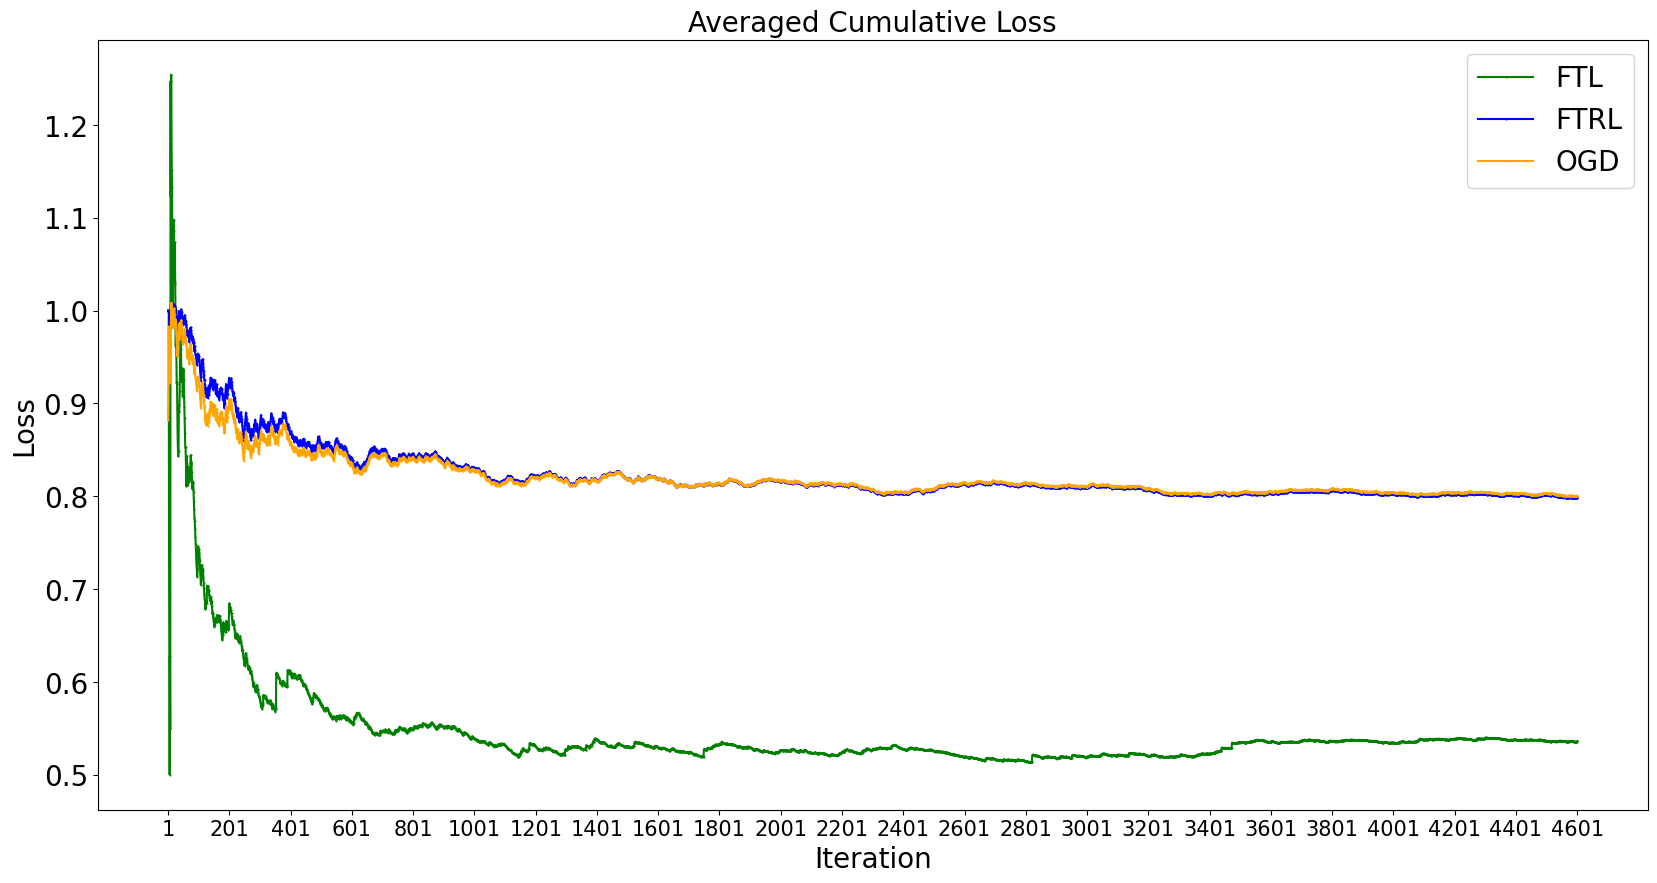

In [110]:
plt.figure(figsize=(20, 10))
plt.plot(
    range(1, T + 1),
    loss_avg3,
    marker=".",
    label="FTL",
    color="green",
    markersize=1
)
plt.plot(
    range(1, T + 1),
    loss_avg,
    marker=".",
    label="FTRL",
    color="blue",
    markersize=1
)
plt.plot(
    range(1, T + 1),
    loss_avg2,
    marker=".",
    label="OGD",
    color="orange",
    markersize=1
)

plt.title("Averaged Cumulative Loss", size=20)
plt.xlabel("Iteration", size=20)
plt.ylabel("Loss", size=20)
plt.xticks(range(1, T + 1, 200), size=15)
plt.yticks(size=20)
plt.legend(prop={'size': 20})
plt.savefig("loss.png")
plt.show()

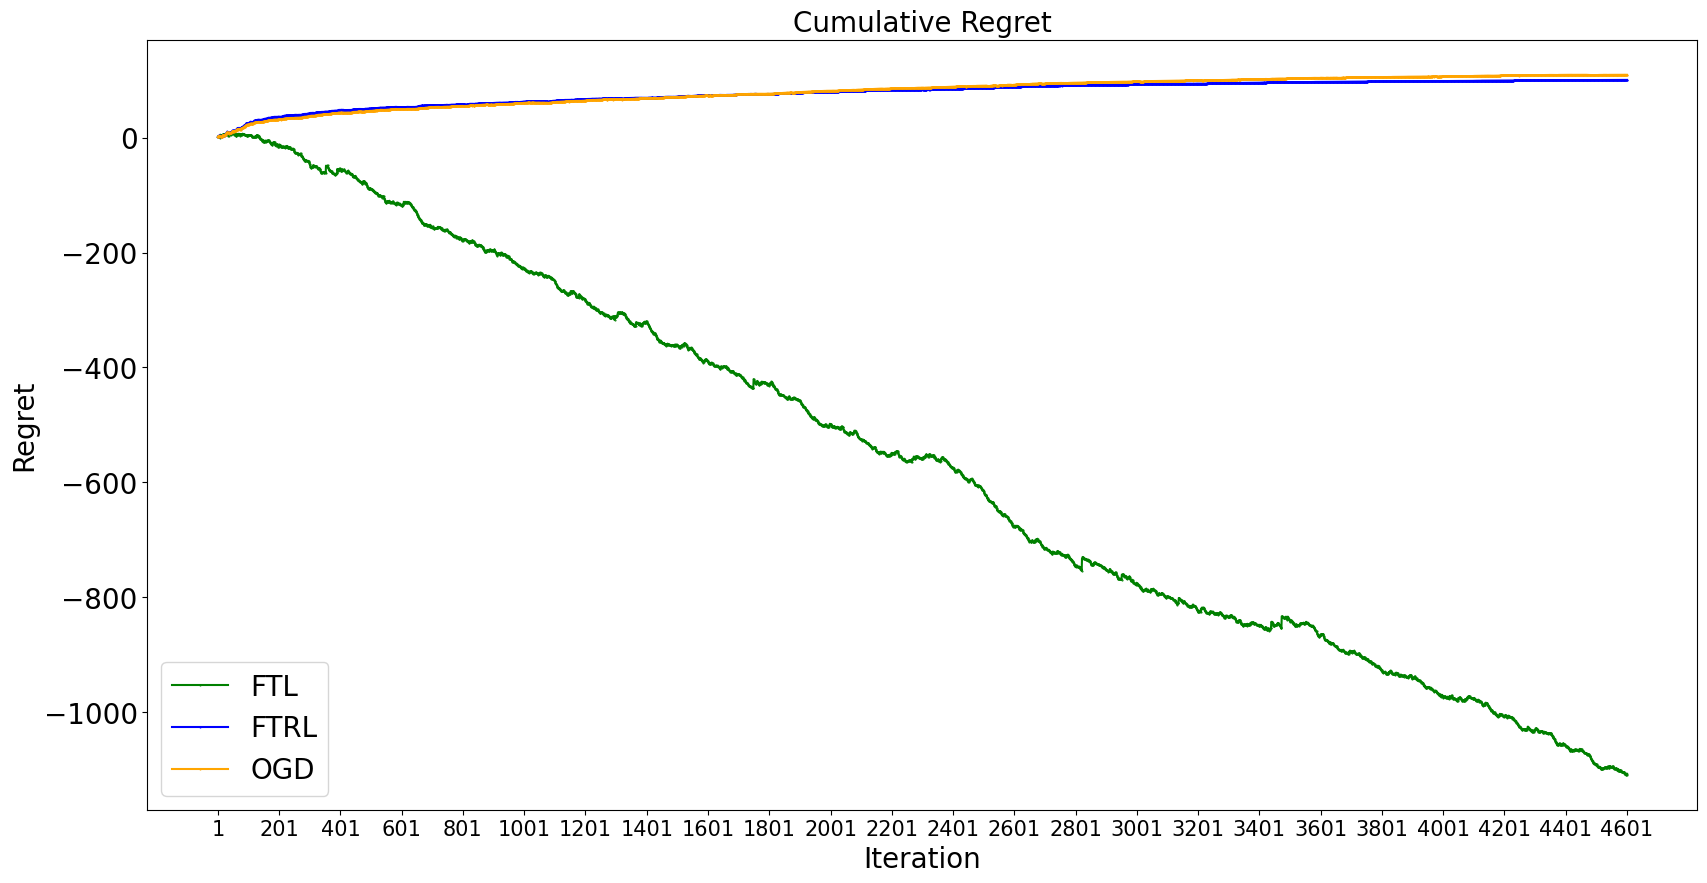

In [ ]:
plt.figure(figsize=(20, 10))
# plt.plot(
#     range(1, T + 1),
#     regret3,
#     marker=".",
#     label="FTL",
#     color="green",
#     markersize=1
# )
plt.plot(
    range(1, T + 1),
    regret,
    marker=".",
    label="FTRL",
    color="blue",
    markersize=1
)
plt.plot(
    range(1, T + 1),
    regret2,
    marker=".",
    label="OGD",
    color="orange",
    markersize=1
)
plt.title("Cumulative Regret", size=20)
plt.xlabel("Iteration", size=20)
plt.ylabel("Regret", size=20)
plt.xticks(range(1, T + 1, 200), size=15)
plt.yticks(size=20)
plt.legend(prop={'size': 20})
plt.savefig("regret.png")
plt.show()